In [1]:
import sys

sys.path.append('../')

import torch

from model.continuous_prompt import ContinuousPromptingLLM
from model.graph_encoder import GraphContinuousPromptModel
from model.projection import BasicProjection

from dataset import GraphDataset
from util import plot_and_save

In [2]:
MODE='train'
TASK='cycle_check'
MODEL_NAME = 'gin-readout2'
SAVE_DIR=f'/home/bonbak/GraphToken/output/{TASK}'
TASKS_DIR = f'/home/bonbak/GraphToken/task/{TASK}'
DEVICE='cuda:2'

In [3]:
train_dataset = GraphDataset(f"{TASKS_DIR}/{MODE}.jsonl")
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)
print('\n'.join((train_dataset.data[0]['node_information'], train_dataset.data[0]['edge_information'], train_dataset.data[0]['question'])))

G describes a graph among nodes 0, 1, 2, 3, 4, and 5.
The edges in G are: (0, 1) (0, 2) (0, 3) (0, 5) (1, 3) (1, 4) (1, 5) (2, 3) (2, 4) (2, 5) (4, 5).
You must answer with "Yes" or "No" under the question.
Q: Is there a cycle in this graph?
A: 


In [4]:
continuous_prompt_model = GraphContinuousPromptModel(input_dim=5, hidden_dim=512)
projection_module = BasicProjection(continuous_prompt_model.model.hidden_dim)

model = ContinuousPromptingLLM(
    "google/gemma-2b-it",
    continuous_prompt_model, 
    continuous_prompt_model.model.hidden_dim
)

continuous_prompt_model.to(DEVICE)
model.to(DEVICE)

for param in model.parameters():
    param.requires_grad = False
for param in model.projection_module.parameters():
    param.requires_grad = True
for param in model.continuous_prompt_model.parameters():
    param.requires_grad = True

optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You must answer with "Yes" or "No" under the question.
Q: Is there a cycle in this graph?
A:  Yes<eos>
step 80 | cur_loss : 0.7803 | min_loss : 0.7803 
You must answer with "Yes" or "No" under the question.
Q: Is there a cycle in this graph?
A:  Yes<eos>
step 160 | cur_loss : 0.6424 | min_loss : 0.6424 
step 240 | cur_loss : 0.6871 | min_loss : 0.6424 
You must answer with "Yes" or "No" under the question.
Q: Is there a cycle in this graph?
A:  Yes<eos>
step 320 | cur_loss : 0.3837 | min_loss : 0.3837 
You must answer with "Yes" or "No" under the question.
Q: Is there a cycle in this graph?
A:  Yes<eos>
step 400 | cur_loss : 0.2572 | min_loss : 0.2572 
step 480 | cur_loss : 0.2909 | min_loss : 0.2572 
You must answer with "Yes" or "No" under the question.
Q: Is there a cycle in this graph?
A:  Yes<eos>
step 560 | cur_loss : 0.1661 | min_loss : 0.1661 
step 640 | cur_loss : 0.1956 | min_loss : 0.1661 
You must answer with "Yes" or "No" under the question.
Q: Is there a cycle in this gra

KeyboardInterrupt: 

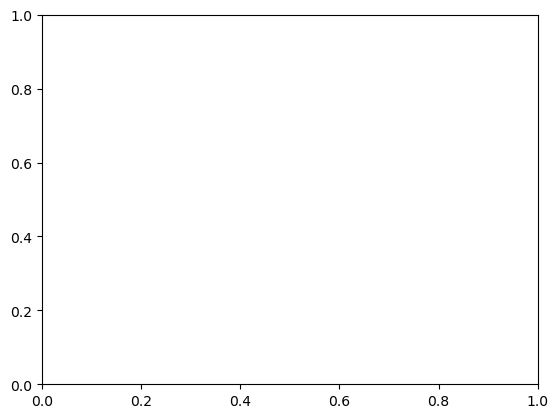

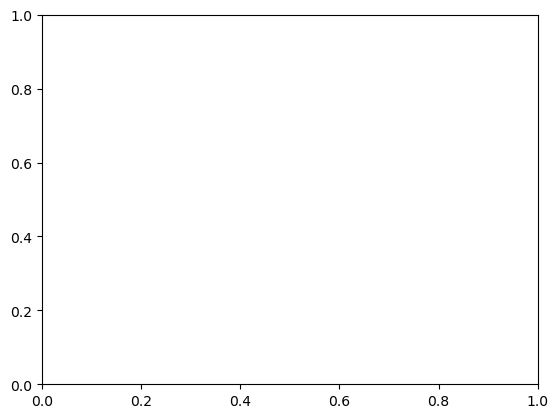

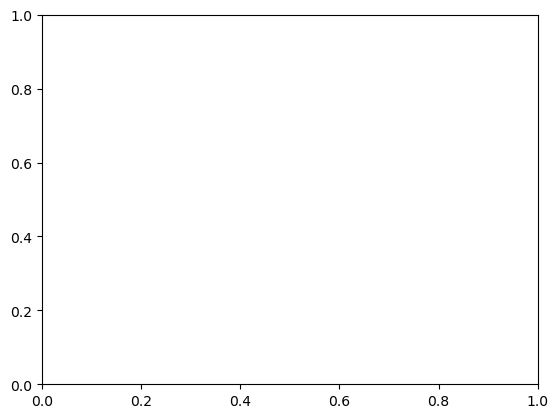

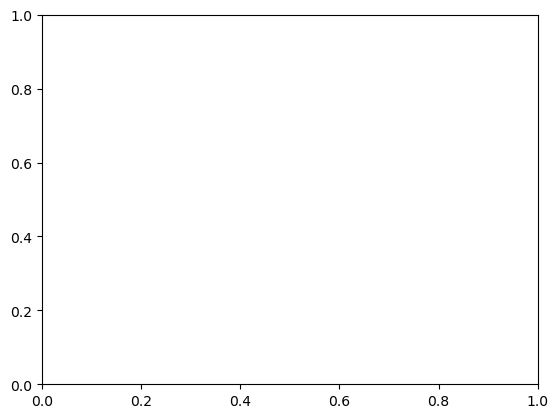

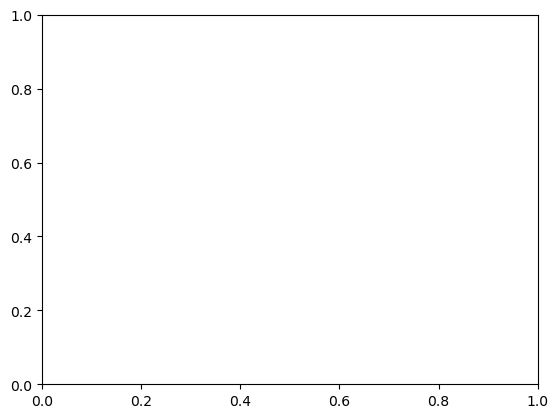

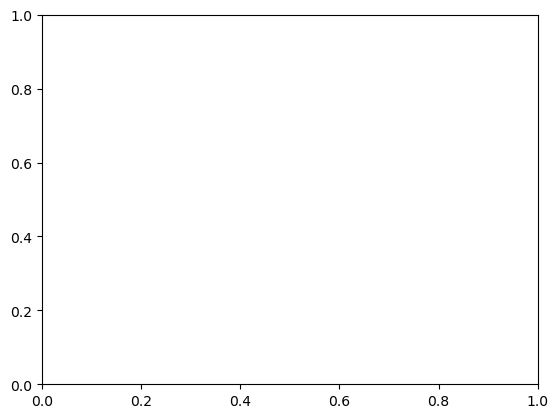

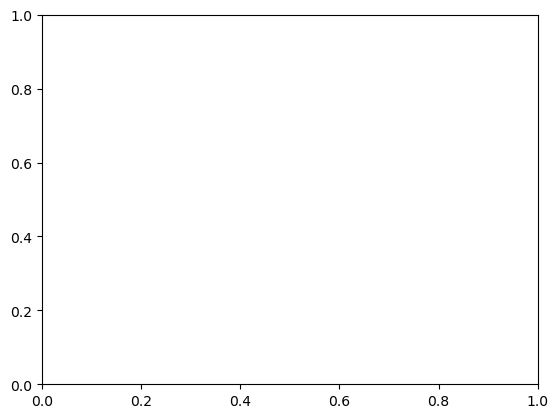

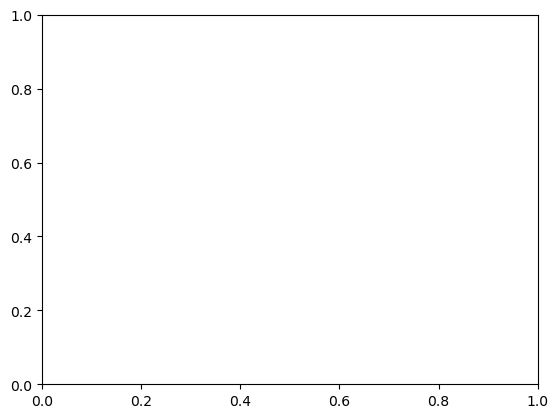

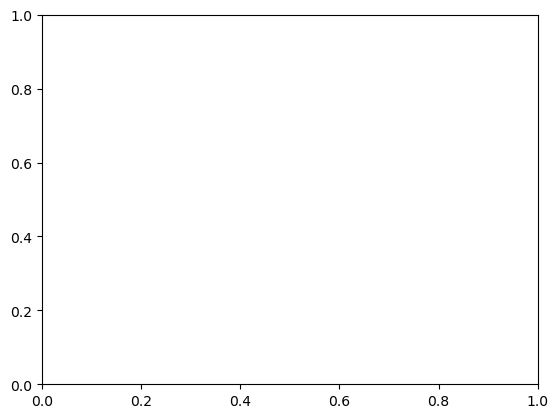

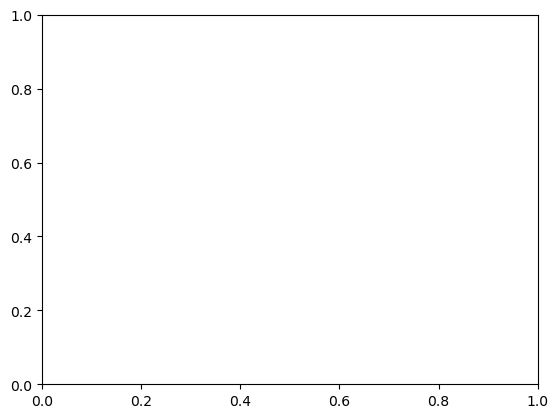

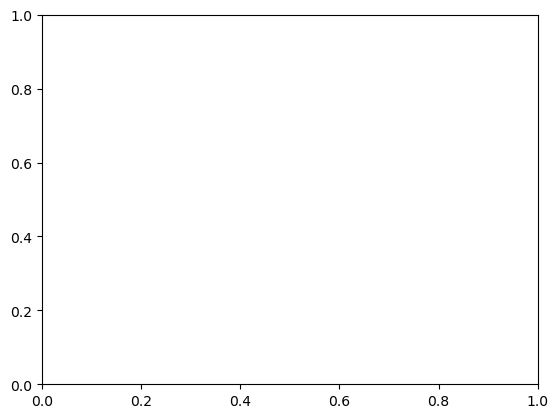

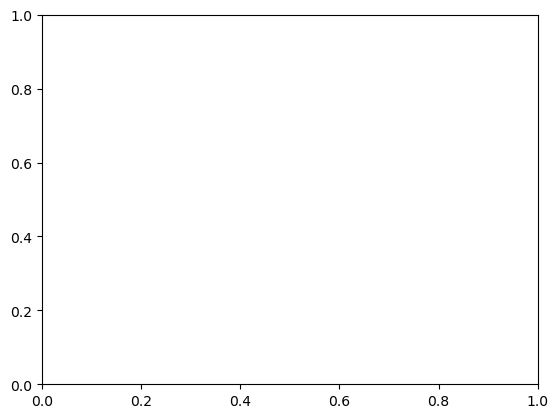

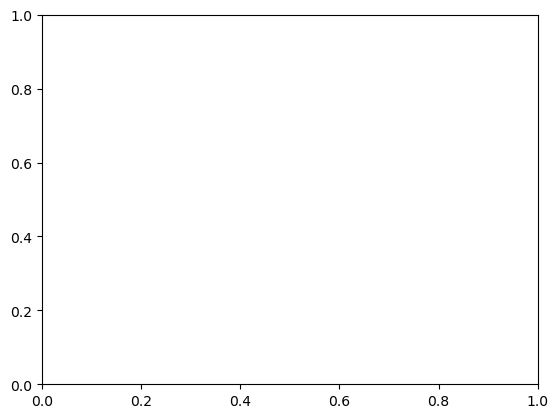

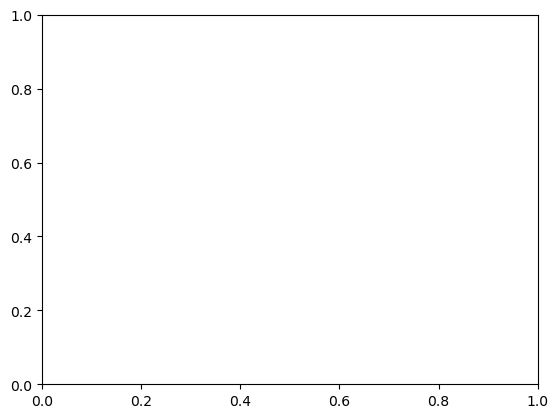

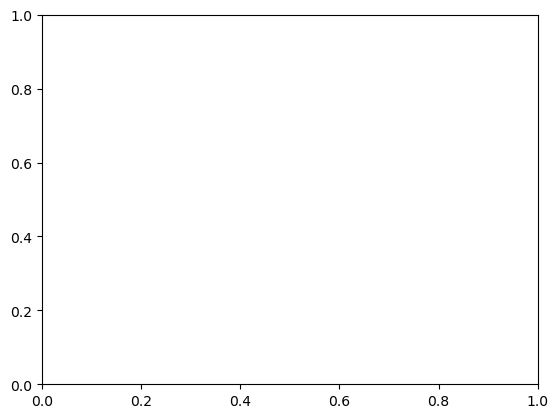

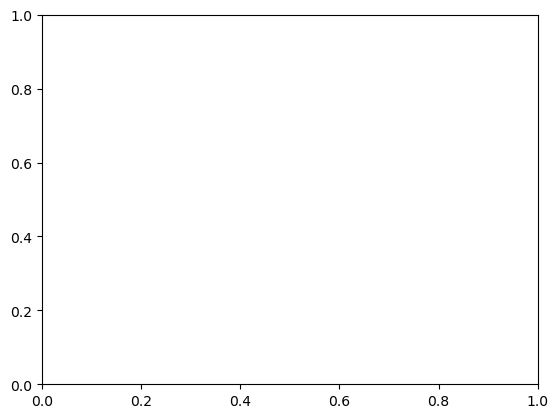

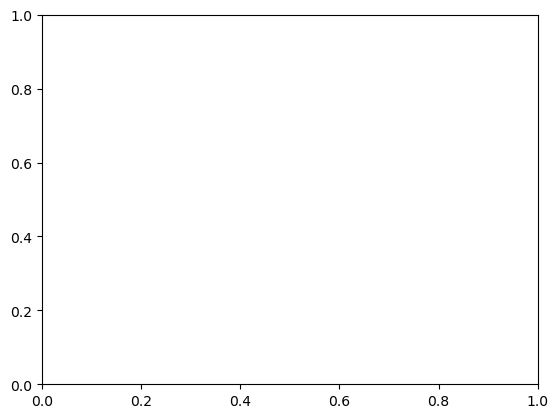

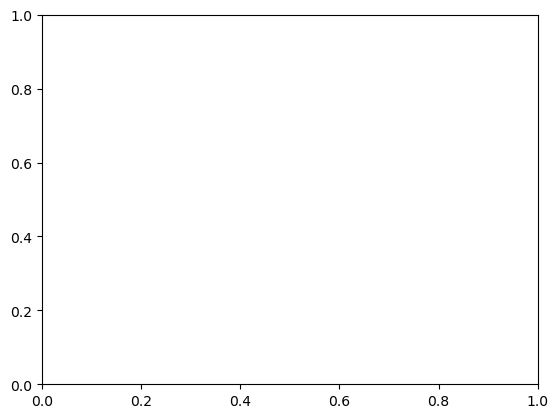

In [5]:
model.train()
c = 0
loss_log_list = []
min_loss = 1000000
accumulate_step = 8

def mean(lst):
    return sum(lst)/len(lst)

for epoch in range(20):
    for input_text, continuous_prompt_input, answer_list in train_dataloader:
        inputs_embeds, attention_mask, labels = model.make_seq2seq_input_label(input_text,continuous_prompt_input,answer_list, embedding_first=True)

        generated_output = model.llm_model.forward(
                    inputs_embeds=inputs_embeds,
                    attention_mask = attention_mask,
                    labels=labels
                )
        generated_output.loss.backward()
        
        if c % accumulate_step == 0:
            optimizer.step()
            optimizer.zero_grad()
        loss_log_list.append(generated_output.loss.item())
        
        if c % 80 == 0 and c!=0:
            cur_loss = mean(loss_log_list[-accumulate_step:])
            if min_loss > cur_loss:
                model.eval()
                model.to('cpu')
                min_loss = cur_loss
                torch.save(model.projection_module.state_dict(), f'{SAVE_DIR}/model/{MODEL_NAME}-projection.bin')
                torch.save(model.continuous_prompt_model.state_dict(), f'{SAVE_DIR}/model/{MODEL_NAME}-encoder.bin')

                inputs_embeds, attention_mask = model.make_input_embed(input_text,continuous_prompt_input, embedding_first=True)
                output = model.llm_model.generate(inputs_embeds=inputs_embeds, attention_mask=attention_mask, max_new_tokens=4)
                print(input_text[0], model.llm_tokenizer.decode(output[0]))
                plot_and_save(loss_log_list, f'{SAVE_DIR}/loss/{MODEL_NAME}.png')

                model.train()
                model.to(DEVICE)

            print(f'step {c} | cur_loss : {cur_loss:.4f} | min_loss : {min_loss:.4f} ')
        c+=1